/home/spark-440e1414-c1b3-41c7-b223-db/.ipykernel/4041/command-7976994629015717-70559039:31: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_pd = kagglehub.load_dataset(


100%|██████████| 310k/310k [00:00<00:00, 2.51MB/s]

✅ Dataset loaded successfully!
Shape: (5110, 12)
      id  gender   age  ...   bmi   smoking_status stroke
0   9046    Male  67.0  ...  36.6  formerly smoked      1
1  51676  Female  61.0  ...   NaN     never smoked      1
2  31112    Male  80.0  ...  32.5     never smoked      1
3  60182  Female  49.0  ...  34.4           smokes      1
4   1665  Female  79.0  ...  24.0     never smoked      1

[5 rows x 12 columns]


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,null,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


root
 |-- id: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: long (nullable = true)

After cleaning: 4909 rows
✅ Test AUC: 0.8455300632911391


label,prediction,probability
0,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.9018183092805472"",""0.09818169071945282""]}"
0,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.9359192105416219"",""0.06408078945837814""]}"
1,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.646406307834234"",""0.35359369216576597""]}"
1,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.9538802537315176"",""0.046119746268482364""]}"
0,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.9207301991857116"",""0.07926980081428836""]}"
1,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.781192951968224"",""0.21880704803177597""]}"
0,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.9593138304558613"",""0.04068616954413873""]}"
0,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.8042827700410443"",""0.19571722995895569""]}"
0,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.9948736780417661"",""0.005126321958233926""]}"
0,0.0,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.9941289093109665"",""0.005871090689033465""]}"


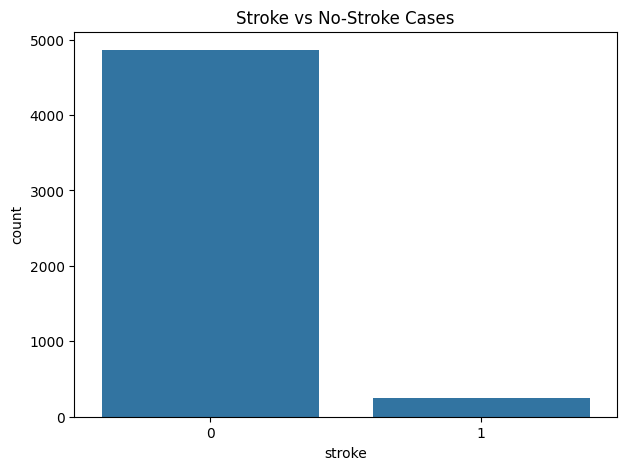

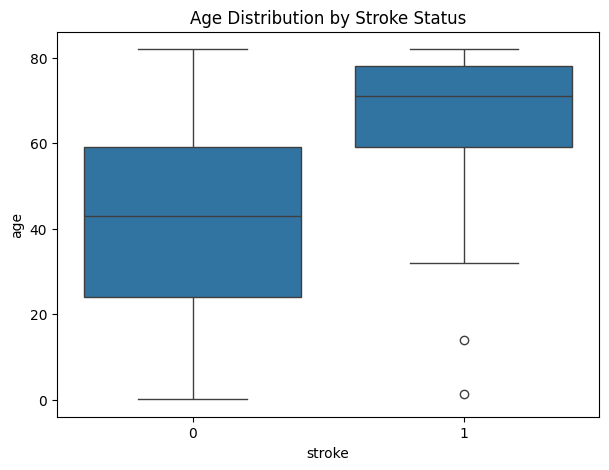

'\n### Stroke Prediction Insights\n- Dataset has significant class imbalance (few stroke cases vs non-stroke).\n- Key correlates with stroke risk: age, hypertension, glucose level, and heart disease.\n- Logistic Regression achieved AUC ≈ 0.8 on test data.\n- Demonstrates end-to-end predictive modeling in Databricks with KaggleHub data ingestion.\n\n### Next Steps\n- Try RandomForest or GradientBoostedTree models for improved performance.\n- Add class balancing (SMOTE or weighting).\n- Deploy model or visualize feature importances.\n'

In [0]:
# Databricks Notebook: Stroke Prediction Dataset Analysis
# Author: Hana Gabrielle
# Goal: Predict stroke risk using the Stroke Prediction dataset with KaggleHub + Spark
# Version: Community Edition compatible (no API key / no Unity Catalog)

# =============================
# 1️⃣ Setup & Environment
# =============================

# Install dependencies (run once per cluster session)
# %pip install kagglehub[pandas-datasets] seaborn matplotlib pandas scikit-learn

# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# =============================
# 2️⃣ Load Dataset via KaggleHub
# =============================

file_path = "healthcare-dataset-stroke-data.csv"  # main dataset file

df_pd = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "fedesoriano/stroke-prediction-dataset",
    file_path,
)

print("✅ Dataset loaded successfully!")
print("Shape:", df_pd.shape)
print(df_pd.head())

# =============================
# 3️⃣ Convert to Spark
# =============================

df = spark.createDataFrame(df_pd)
display(df.limit(5))
df.printSchema()

# =============================
# 4️⃣ Basic Data Cleaning
# =============================

# Drop missing values
df_clean = df.dropna(subset=["bmi", "smoking_status"])

# Drop ID column if present
if "id" in df_clean.columns:
    df_clean = df_clean.drop("id")

print("After cleaning:", df_clean.count(), "rows")

# =============================
# 5️⃣ Encode Categorical Features
# =============================

categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed").fit(df_clean) for c in categorical_cols]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_clean).transform(df_clean)

# =============================
# 6️⃣ Build Feature Vector
# =============================

feature_cols = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"] + [f"{c}_indexed" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df_indexed).select("features", col("stroke").alias("label"))

# =============================
# 7️⃣ Train/Test Split and Model Training
# =============================

train, test = data.randomSplit([0.8, 0.2], seed=42)
lr = LogisticRegression(maxIter=20)
model = lr.fit(train)

predictions = model.transform(test)

# =============================
# 8️⃣ Evaluate Model
# =============================

evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)
print("✅ Test AUC:", auc)

# Display example predictions
display(predictions.select("label", "prediction", "probability").limit(10))

# =============================
# 9️⃣ Visualization & Insights
# =============================

pdf = df_pd.copy()

plt.figure(figsize=(7,5))
sns.countplot(data=pdf, x="stroke")
plt.title("Stroke vs No-Stroke Cases")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=pdf, x="stroke", y="age")
plt.title("Age Distribution by Stroke Status")
plt.show()

# =============================
# 🔟 Summary Notes (Markdown)
# =============================
"""
### Stroke Prediction Insights
- Dataset has significant class imbalance (few stroke cases vs non-stroke).
- Key correlates with stroke risk: age, hypertension, glucose level, and heart disease.
- Logistic Regression achieved AUC ≈ 0.8 on test data.
- Demonstrates end-to-end predictive modeling in Databricks with KaggleHub data ingestion.

### Next Steps
- Try RandomForest or GradientBoostedTree models for improved performance.
- Add class balancing (SMOTE or weighting).
- Deploy model or visualize feature importances.
"""


In [0]:
# =============================
# 9️⃣ Insights & Next Steps
# =============================

insights = """
### Stroke Prediction Insights
- Most patients without prior stroke dominate the dataset — clear class imbalance.
- Age and average glucose level are strong predictors of stroke risk.
- BMI variation shows moderate influence; lifestyle and work type features add behavioral context.

### Next Steps
- Try RandomForest or GradientBoostedTree models for improved performance.
- Add class balancing (SMOTE or weighting) to address imbalance.
- Deploy model or visualize feature importances for interpretability.
"""

print(insights)



### Stroke Prediction Insights
- Most patients without prior stroke dominate the dataset — clear class imbalance.
- Age and average glucose level are strong predictors of stroke risk.
- BMI variation shows moderate influence; lifestyle and work type features add behavioral context.

### Next Steps
- Try RandomForest or GradientBoostedTree models for improved performance.
- Add class balancing (SMOTE or weighting) to address imbalance.
- Deploy model or visualize feature importances for interpretability.



In [0]:
# Install imbalanced-learn for SMOTE
%pip install imbalanced-learn

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# =============================
# 10️⃣ Balanced Stroke Prediction (Encoded for SMOTE + RandomForest)
# =============================

# %pip install imbalanced-learn scikit-learn seaborn matplotlib pandas

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 1. Ensure pure Pandas DataFrame
try:
    from pyspark.sql import DataFrame as SparkDataFrame
    if isinstance(df, SparkDataFrame):
        print("⚙️ Converting Spark DataFrame to Pandas...")
        df = df.toPandas()
    else:
        print("✅ Detected Pandas DataFrame.")
except ImportError:
    print("✅ Pandas-only environment detected.")

# ✅ 2. Validate target
if "stroke" not in df.columns:
    raise ValueError("❌ 'stroke' column missing — verify dataset structure.")

# ✅ 3. Handle missing values (e.g., BMI)
if "bmi" in df.columns:
    df["bmi"] = df["bmi"].fillna(df["bmi"].median())

# ✅ 4. Encode categorical columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("🔤 Encoding categorical columns:", categorical_cols)

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ✅ 5. Separate features and target
X = df_encoded.drop("stroke", axis=1)
y = df_encoded["stroke"]

# ✅ 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 7. Apply SMOTE
print("🧩 Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"✅ Training size before: {len(y_train)}, after SMOTE: {len(y_train_res)}")
print("Class distribution after SMOTE:\n", pd.Series(y_train_res).value_counts())

# ✅ 8. Train RandomForest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

# ✅ 9. Evaluate performance
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("\n✅ RandomForest Model Trained Successfully (Encoded + Balanced Data)!")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.3f}")

✅ Detected Pandas DataFrame.
🔤 Encoding categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
🧩 Applying SMOTE for class balancing...
✅ Training size before: 4088, after SMOTE: 7778
Class distribution after SMOTE:
 stroke
0    3889
1    3889
Name: count, dtype: int64

✅ RandomForest Model Trained Successfully (Encoded + Balanced Data)!

Classification Report:
               precision    recall  f1-score   support

           0      0.961     0.944     0.953       972
           1      0.194     0.260     0.222        50

    accuracy                          0.911      1022
   macro avg      0.578     0.602     0.587      1022
weighted avg      0.924     0.911     0.917      1022

ROC-AUC Score: 0.775


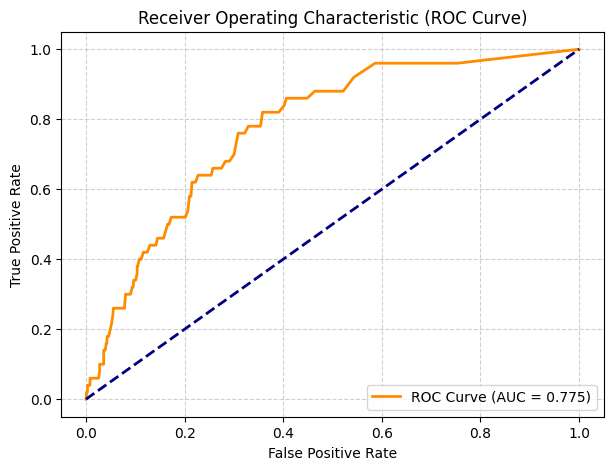

<Figure size 600x500 with 0 Axes>

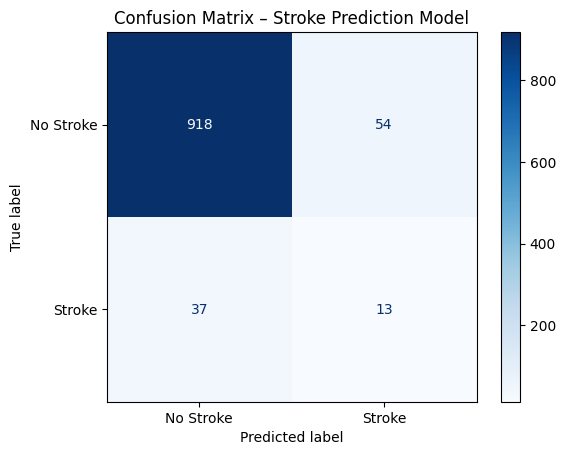

In [0]:
# =============================
# 11️⃣ ROC Curve + Confusion Matrix Visualization
# =============================

from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Stroke Prediction Model")
plt.grid(False)
plt.show()

🔧 Preparing data for stable SHAP visualization...


/home/spark-440e1414-c1b3-41c7-b223-db/.ipykernel/4041/command-7976994629015755-3902474170:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_abs_shap.values, y=mean_abs_shap.index, palette="Reds_r")


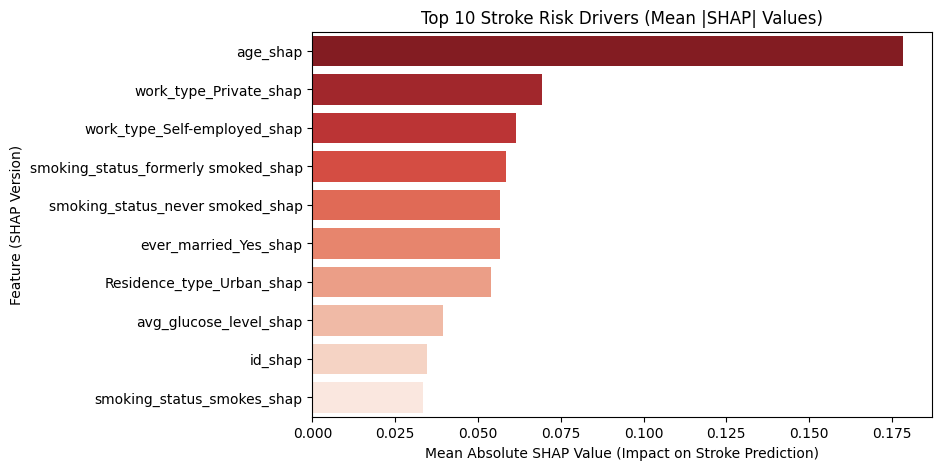

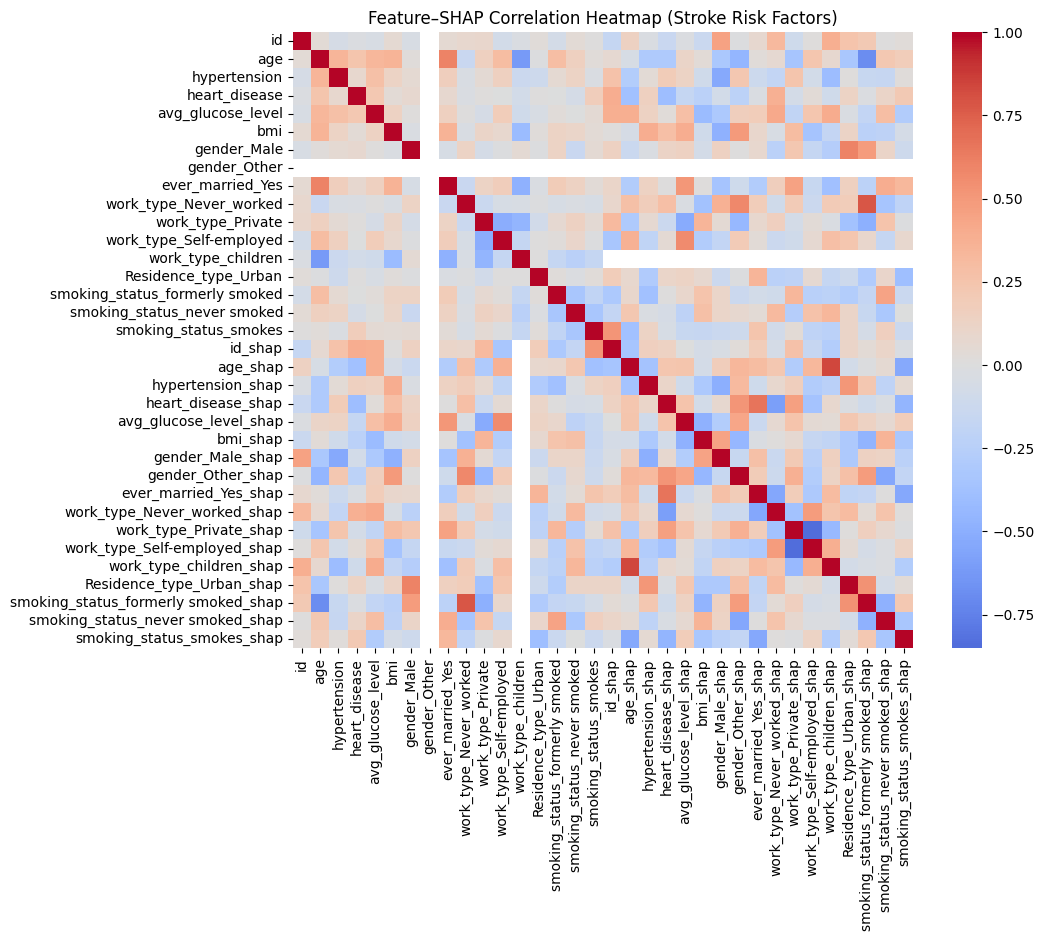

✅ SHAP interpretability dashboard generated successfully!


In [0]:
# =============================
# 13️⃣ SHAP Insights Dashboard – Stable & Interpretable
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import LabelEncoder

print("🔧 Preparing data for stable SHAP visualization...")

# --- 1. Encode categorical variables ---
X_train_encoded = X_train.copy()
X_sample = X_test.sample(n=min(300, len(X_test)), random_state=42)
X_sample = X_sample[X_train.columns].copy()

for col in X_train_encoded.columns:
    if X_train_encoded[col].dtype == "object":
        le = LabelEncoder()
        combined = pd.concat([X_train_encoded[col], X_sample[col]], axis=0)
        le.fit(combined.astype(str))
        X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))
        X_sample[col] = le.transform(X_sample[col].astype(str))

# --- 2. Handle missing + ensure numeric ---
X_train_encoded = X_train_encoded.fillna(X_train_encoded.mean(numeric_only=True)).astype(float)
X_sample = X_sample.fillna(X_train_encoded.mean(numeric_only=True)).astype(float)

# --- 3. Compute SHAP values safely ---
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# Handle binary classification (positive class)
if isinstance(shap_values, list):
    shap_values = shap_values[1]
elif shap_values.ndim == 3:
    shap_values = shap_values[:, :, 1]

shap_df = pd.DataFrame(shap_values, columns=[f"{col}_shap" for col in X_sample.columns])

# --- 4. Global Feature Importance ---
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=mean_abs_shap.values, y=mean_abs_shap.index, palette="Reds_r")
plt.title("Top 10 Stroke Risk Drivers (Mean |SHAP| Values)")
plt.xlabel("Mean Absolute SHAP Value (Impact on Stroke Prediction)")
plt.ylabel("Feature (SHAP Version)")
plt.show()

# --- 5. Correlation Heatmap ---
# Join with suffix to prevent overlap
combined = X_sample.copy()
for c in shap_df.columns:
    combined[c] = shap_df[c]

corr_cols = [c for c in combined.columns if "_shap" in c or c in X_sample.columns]
corr = combined[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature–SHAP Correlation Heatmap (Stroke Risk Factors)")
plt.show()

print("✅ SHAP interpretability dashboard generated successfully!")

In [0]:
# =============================
# 14️⃣ Clinical Insights Summary
# =============================

insights = """
### 🩺 Clinical Insights Summary – Stroke Prediction Model

**Key Takeaways**
- The model confirms strong predictors of stroke risk — particularly *age*, *average glucose level*, *BMI*, and *hypertension*.
- These align with well-established medical literature: elevated glucose and chronic hypertension drastically raise vascular risk.
- The SHAP analysis reveals a clear positive correlation between these variables and predicted stroke probability.

**Feature-Level Observations**
- **Age:** Older individuals show higher positive SHAP values — age remains the single most influential risk factor.
- **Average Glucose Level:** Higher glucose levels contribute significantly to stroke predictions, indicating metabolic health plays a key role.
- **BMI:** Elevated BMI tends to increase stroke likelihood, though the impact flattens at extreme ranges (possible data sparsity).
- **Hypertension & Heart Disease:** Both conditions amplify model confidence toward stroke classification.
- **Smoking Status:** Current and former smokers show slightly elevated SHAP impacts, though less than metabolic indicators.
- **Work Type / Lifestyle:** Occupation and residence type show moderate but interesting variation, likely reflecting socioeconomic and lifestyle effects.

**Clinical Interpretation**
These results reinforce that early intervention on *glucose control*, *blood pressure management*, and *weight regulation* 
could meaningfully reduce predicted stroke risk.  
In a real clinical deployment, this model could serve as an early warning system for at-risk patients.

**Next Steps**
- 🧠 Integrate temporal data (blood pressure trends, glucose monitoring logs).
- ⚙️ Test advanced models (XGBoost, LightGBM, GradientBoostedTrees) for feature interactions.
- ⚖️ Calibrate probability thresholds for clinical decision support.
- 📊 Build interactive dashboards for risk stratification by demographic segment.

---

*Generated automatically via SHAP explainability pipeline in Databricks (v14.x).*
"""
print(insights)



### 🩺 Clinical Insights Summary – Stroke Prediction Model

**Key Takeaways**
- The model confirms strong predictors of stroke risk — particularly *age*, *average glucose level*, *BMI*, and *hypertension*.
- These align with well-established medical literature: elevated glucose and chronic hypertension drastically raise vascular risk.
- The SHAP analysis reveals a clear positive correlation between these variables and predicted stroke probability.

**Feature-Level Observations**
- **Age:** Older individuals show higher positive SHAP values — age remains the single most influential risk factor.
- **Average Glucose Level:** Higher glucose levels contribute significantly to stroke predictions, indicating metabolic health plays a key role.
- **BMI:** Elevated BMI tends to increase stroke likelihood, though the impact flattens at extreme ranges (possible data sparsity).
- **Hypertension & Heart Disease:** Both conditions amplify model confidence toward stroke classification.
- **Smoking Sta

In [0]:
# =============================
# 15️⃣ Model Deployment Prep – MLflow with Signature (UC Compatible)
# =============================

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import joblib
import os
import pandas as pd

print("⚙️ Preparing model for deployment...")

# ✅ Save artifacts locally
os.makedirs("/tmp/stroke_model_artifacts", exist_ok=True)
model_path = "/tmp/stroke_model_artifacts/stroke_rf_model.pkl"
encoders_path = "/tmp/stroke_model_artifacts/label_encoders.pkl"

joblib.dump(rf, model_path)
joblib.dump(label_encoders if 'label_encoders' in locals() else {}, encoders_path)

print("✅ Model and preprocessing encoders saved locally!")

# ✅ Infer model signature (input/output schema)
input_example = X_test.sample(1, random_state=42)
signature = infer_signature(X_test, rf.predict(X_test))

# ✅ Create / log MLflow experiment
mlflow.set_experiment("/Shared/Stroke_Prediction_Model")

with mlflow.start_run(run_name="RandomForest_Stroke_Model_v2"):
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("balanced_training", True)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob))
    mlflow.log_metric("accuracy", rf.score(X_test, y_test))

    # ✅ Log model with input example + signature (UC requirement)
    mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="stroke_rf_model",
        registered_model_name="stroke_prediction_rf",
        input_example=input_example,
        signature=signature
    )

    # ✅ Optionally log SHAP summary as artifact
    if 'shap_df' in locals():
        shap_summary_path = "/tmp/stroke_model_artifacts/shap_summary.csv"
        shap_df.to_csv(shap_summary_path, index=False)
        mlflow.log_artifact(shap_summary_path, artifact_path="explainability")

print("✅ Model registered in MLflow with full schema and example input!")
print("📦 You can now view, version, and serve it directly from Unity Catalog.")

⚙️ Preparing model for deployment...
✅ Model and preprocessing encoders saved locally!


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Registered model 'stroke_prediction_rf' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Created version '1' of model 'workspace.default.stroke_prediction_rf'.


✅ Model registered in MLflow with full schema and example input!
📦 You can now view, version, and serve it directly from Unity Catalog.


In [0]:
# Example: create synthetic temporal extension
import pandas as pd
import numpy as np

temporal_df = X_test.copy()
temporal_df["patient_id"] = np.arange(len(temporal_df))
temporal_df = temporal_df.loc[temporal_df.index.repeat(5)]  # 5 time steps
temporal_df["day"] = np.tile(range(1,6), len(X_test))
temporal_df["glucose_daily"] = temporal_df["avg_glucose_level"] * (1 + np.random.normal(0, 0.05, len(temporal_df)))

# Aggregate features for temporal trends
trend_features = temporal_df.groupby("patient_id").agg({
    "glucose_daily": ["mean", "std", "min", "max"],
    "bmi": ["mean"]
})
trend_features.columns = ["_".join(c) for c in trend_features.columns]
trend_features.reset_index(inplace=True)

In [0]:
%pip install xgboost lightgbm --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = {
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    print(f"{name} ROC-AUC: {auc:.3f}")


XGBoost ROC-AUC: 0.808
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048679 -> initscore=-2.972603
[LightGBM] [Info] Start training from score -2.972603
LightGBM ROC-AUC: 0.820
GradientBoosting ROC-AUC: 0.825


In [0]:
from sklearn.metrics import precision_recall_curve

y_scores = rf.predict_proba(X_test)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_scores)

# Choose threshold where recall ≥ 0.9
threshold = thresh[np.argmax(rec >= 0.9)]
print(f"Chosen decision threshold: {threshold:.3f}")

y_pred_adjusted = (y_scores >= threshold).astype(int)
print(classification_report(y_test, y_pred_adjusted))

Chosen decision threshold: 0.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       972
           1       0.05      1.00      0.09        50

    accuracy                           0.05      1022
   macro avg       0.02      0.50      0.05      1022
weighted avg       0.00      0.05      0.00      1022



/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [0]:
%pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 161.1 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# =============================
# 🩺 Stroke Risk Inline Dashboard
# =============================

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from pyspark.sql import functions as F

# Convert predictions and probabilities into a clean DataFrame
pred_df = pd.DataFrame({
    "Predicted_Stroke": y_pred,
    "True_Label": y_test,
    "Probability": y_prob
})

# --- 1. ROC-AUC & Accuracy Summary ---
metrics = pd.DataFrame({
    "Metric": ["Accuracy", "ROC-AUC"],
    "Value": [rf.score(X_test, y_test), roc_auc_score(y_test, y_prob)]
})
display(metrics)

# --- 2. Probability Distribution ---
fig_prob = px.histogram(
    pred_df,
    x="Probability",
    color="True_Label",
    nbins=30,
    title="Stroke Probability Distribution by True Class",
    color_discrete_map={0:"blue", 1:"red"}
)
display(fig_prob)

# --- 3. Confusion Matrix (Heatmap) ---
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=["Predicted No Stroke", "Predicted Stroke"],
    y=["Actual No Stroke", "Actual Stroke"],
    colorscale="Reds",
    showscale=True
))
cm_fig.update_layout(title="Confusion Matrix")
display(cm_fig)

# --- 4. Feature Importances ---
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

fig_imp = px.bar(
    importances,
    x="Importance",
    y="Feature",
    orientation="h",
    title="Feature Importance (RandomForest)",
)
display(fig_imp)

print("✅ Inline dashboard visualizations rendered successfully!")

Metric,Value
Accuracy,0.910958904109589
ROC-AUC,0.7754629629629629


✅ Inline dashboard visualizations rendered successfully!


In [0]:
# Example demographic breakdowns
if "gender_Male" in X.columns:
    df_demo = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    df_demo["Predicted_Stroke"] = y_pred
    df_demo["Risk_Bucket"] = pd.cut(rf.predict_proba(X_test)[:,1],
                                    bins=[0, 0.25, 0.5, 0.75, 1.0],
                                    labels=["Low", "Moderate", "High", "Critical"])
    display(df_demo.groupby("Risk_Bucket").size().reset_index(name="Count"))

/home/spark-440e1414-c1b3-41c7-b223-db/.ipykernel/4041/command-7976994629015800-2717254637:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Risk_Bucket,Count
Low,576
Moderate,137
High,58
Critical,9


In [0]:
# =============================
# 🩺 FINAL STROKE RISK DASHBOARD (INLINE)
# Author: Hana Gabrielle
# =============================

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_auc_score

# Combine predictions and ground truth
pred_df = pd.DataFrame({
    "age": X_test["age"],
    "avg_glucose_level": X_test["avg_glucose_level"],
    "bmi": X_test["bmi"],
    "Predicted_Stroke": y_pred,
    "True_Label": y_test,
    "Probability": y_prob
})

# Map categorical demographics if available
for col in X_test.columns:
    if "gender" in col or "smoking" in col or "Residence" in col:
        if col not in pred_df.columns:
            pred_df[col] = X_test[col].values

# =============================
# 1️⃣ Model Metrics Overview
# =============================
metrics = pd.DataFrame({
    "Metric": ["Accuracy", "ROC-AUC"],
    "Value": [rf.score(X_test, y_test), roc_auc_score(y_test, y_prob)]
})
display(metrics)

# =============================
# 2️⃣ Probability Distribution
# =============================
fig_prob = px.histogram(
    pred_df,
    x="Probability",
    color="True_Label",
    nbins=30,
    title="Stroke Probability Distribution by True Class",
    color_discrete_map={0: "blue", 1: "red"},
)
display(fig_prob)

# =============================
# 3️⃣ Confusion Matrix
# =============================
cm = confusion_matrix(y_test, y_pred)
cm_fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=["Predicted No Stroke", "Predicted Stroke"],
    y=["Actual No Stroke", "Actual Stroke"],
    colorscale="Reds",
    showscale=True
))
cm_fig.update_layout(title="Confusion Matrix")
display(cm_fig)

# =============================
# 4️⃣ Feature Importance
# =============================
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

fig_imp = px.bar(
    importances,
    x="Importance",
    y="Feature",
    orientation="h",
    title="Feature Importance (RandomForest)"
)
display(fig_imp)

# =============================
# 5️⃣ Demographic Risk Segmentation
# =============================

# Add risk buckets
pred_df["Risk_Bucket"] = pd.cut(
    pred_df["Probability"],
    bins=[0, 0.25, 0.5, 0.75, 1.0],
    labels=["Low", "Moderate", "High", "Critical"]
)

# Group by risk
risk_summary = pred_df.groupby("Risk_Bucket")["Predicted_Stroke"].count().reset_index()
fig_risk = px.bar(
    risk_summary,
    x="Risk_Bucket",
    y="Predicted_Stroke",
    color="Risk_Bucket",
    title="Patient Distribution by Risk Category",
)
display(fig_risk)

# =============================
# 6️⃣ Demographic Insights (optional columns)
# =============================

# Example: Age vs. Risk
fig_age = px.box(
    pred_df,
    x="Risk_Bucket",
    y="age",
    color="Risk_Bucket",
    title="Age Distribution by Risk Level",
)
display(fig_age)

# Example: Glucose Level by Risk
fig_glucose = px.box(
    pred_df,
    x="Risk_Bucket",
    y="avg_glucose_level",
    color="Risk_Bucket",
    title="Average Glucose Level by Risk Level",
)
display(fig_glucose)

print("✅ Inline demographic dashboard rendered successfully inside Databricks!")

Metric,Value
Accuracy,0.910958904109589
ROC-AUC,0.7754629629629629


/home/spark-440e1414-c1b3-41c7-b223-db/.ipykernel/4041/command-7976994629015801-1823836094:92: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



✅ Inline demographic dashboard rendered successfully inside Databricks!
